In [1]:
import theano.sandbox.cuda
theano.sandbox.cuda.use('gpu0') # some other variable would need to be set with the gpuarray backend

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5103)


In [2]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from glob import glob
import scipy.io as sio
from scipy import ndimage as nd
from scipy.stats import pearsonr
from scipy import misc
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import PIL.Image as pim
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import theano
import theano.tensor as T

import src.numpy_utility as pnu
import src.fwrf as prf
from src.fwrf import FWRF_model, fpX
from src.plots import display_candidate_loss
from src.data_preparation import preprocess_gabor_feature_maps

theano floatX: float32
numpy floatX: <type 'numpy.float32'>


In [3]:
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())

root_dir   = os.getcwd() + '/'
output_dir = root_dir+"output/"

print "Time Stamp: %s" % timestamp

Time Stamp: Jun-07-2017_1518


# 1a) Load the image dataset (the images that were presented to the subject for which we have voxel data)

## Load vim-1 dataset

In [4]:
dataset_dir = "/home/styvesg/Documents/PostDoc/Datasets/vim-1/"

In [5]:
stimuli_lowrez = sio.loadmat(dataset_dir+"Stimuli.mat") ### this loads a low-rez version of the stimuli
print stimuli_lowrez.keys()

trn_size = len(stimuli_lowrez["stimTrn"])
val_size = len(stimuli_lowrez["stimVal"])
data_size = trn_size + val_size

print "trn: %d, val: %d" % (trn_size, val_size)

['seqTrn', '__header__', '__globals__', 'stimVal', 'seqVal', 'stimTrn', '__version__']
trn: 1750, val: 120


In [6]:
train_stim_files = glob(dataset_dir+"Stimuli_Trn_FullRes*.mat")
val_stim_file = dataset_dir+"Stimuli_Val_FullRes.mat"

In [7]:
##load validation stim
val_h5 = h5py.File(val_stim_file,'r')
val_stimuli_hirez = np.transpose(val_h5['stimVal'][:],[2,1,0]).astype(fpX)
val_h5.close()

##allocate memory for stim
hirez_resolution = val_stimuli_hirez.shape[1:3]
trn_stimuli_hirez = np.zeros((trn_size,)+hirez_resolution ,dtype=fpX)

##load training stim
cnt = 0
for sl in sorted(train_stim_files):
    this_h5 = h5py.File(sl,'r')
    this_train_stim = this_h5['stimTrn']
    this_num_stim = this_train_stim.shape[-1]
    trn_stimuli_hirez[cnt:cnt+this_num_stim,:,:] = np.transpose(this_train_stim[:],[2,1,0])
    cnt += this_num_stim
    this_h5.close()

## Convert to resolution of the network input

In [8]:
npx = 227
npc = 1

#trn_source = stimuli_lowrez["stimTrn"]
#val_source = stimuli_lowrez["stimVal"]
trn_source = trn_stimuli_hirez
val_source = val_stimuli_hirez

stim_data = np.ndarray(shape=(data_size, npx, npx, npc), dtype=fpX)

for i,rawim in enumerate(trn_source):
    rawmin, rawmax = np.min(rawim), np.max(rawim)
    sim = (rawim - rawmin) * 255 / (rawmax - rawmin)               
    im = pim.fromarray(sim, mode='F').resize((npx, npx), resample=pim.BILINEAR).convert('RGB')
    
    stim_data[i,...] = np.mean(np.asarray(im), axis=2, keepdims=True)

for i,rawim in enumerate(val_source):
    rawmin, rawmax = np.min(rawim), np.max(rawim)
    sim = (rawim - rawmin) * 255 / (rawmax - rawmin)         
    im = pim.fromarray(sim, mode='F').resize((npx, npx), resample=pim.BILINEAR).convert('RGB')
    stim_data[trn_size+i,...] = np.mean(np.asarray(im), axis=2, keepdims=True)
        
stim_data = np.transpose((stim_data - 128) / 128, (0,3,1,2))
print "Data shape = %s" % (stim_data.shape,)

trn_stim_data = stim_data[:trn_size]
val_stim_data = stim_data[trn_size:]

Data shape = (1870, 1, 227, 227)


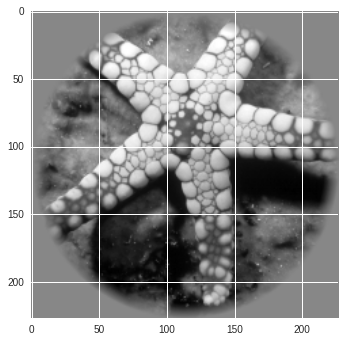

In [9]:
plt.imshow(trn_stim_data[5,0,:,:], cmap='gray')

# 1b) Load the corresponding voxel data

In [10]:
voxelset = h5py.File(dataset_dir+"EstimatedResponses.mat")
print voxelset.keys()

[u'dataTrnS1', u'dataTrnS2', u'dataValS1', u'dataValS2', u'roiS1', u'roiS2', u'voxIdxS1', u'voxIdxS2']


In [11]:
subject = 'S1'
roi_names = ['other', 'V1', 'V2', 'V3', 'V3a', 'V3b', 'V4', 'LO']

In [12]:
voxeldata = np.concatenate([voxelset['dataTrn%s'%subject], voxelset['dataVal%s'%subject]], axis=0).astype(dtype=fpX)
voxelroi = voxelset['roi%s'%subject]
voxelidx = voxelset['voxIdx%s'%subject]
print voxeldata.shape

voxelNanMask = ~np.isnan(voxeldata).any(axis=0)
nv = np.sum(voxelNanMask)
print "%d voxels contain valid values for all images" % nv

(1870, 25915)
22701 voxels contain valid values for all images


In [13]:
voxel_data = voxeldata[:, voxelNanMask].astype(dtype=fpX)
voxelROI  = voxelroi[:, voxelNanMask]
voxelIDX  = voxelidx[:, voxelNanMask]
print voxel_data.shape

trn_voxel_data = voxel_data[:trn_size]
val_voxel_data = voxel_data[trn_size:]

(1870, 22701)


### (Optional) Restricted set of voxels

In [14]:
nv = 1000
start_v = (3566 // nv) * nv
trn_voxel_data = trn_voxel_data[:, start_v:start_v+nv]
val_voxel_data = val_voxel_data[:, start_v:start_v+nv]

# 0) Create the feature space and generate the feature maps for the dataset

In [15]:
model_name = 'gabor'
from gaborizer.src.gabor_feature_dictionaries import gabor_feature_maps

In [16]:
n_orientations = 4
deg_per_stimulus = 20.
lowest_sp_freq = .25 ##cyc/deg
highest_sp_freq = 6. #4.664387 #6.25
num_sp_freq = 12
pix_per_cycle = 3.13333333
complex_cell = True

print 'D = total number of features = %d' %(n_orientations * num_sp_freq)

D = total number of features = 48


In [17]:
gfm = gabor_feature_maps(n_orientations,
                         deg_per_stimulus,
                         (lowest_sp_freq,highest_sp_freq,num_sp_freq),
                         pix_per_cycle=pix_per_cycle, complex_cell=complex_cell,
                         diams_per_filter = 4,
                         cycles_per_radius = 1.0)

In [18]:
print gfm.filter_stack.shape
gfm.gbr_table.head(17)

(48, 1, 25, 25)


,cycles per deg.,cycles_per_filter,filter size (deg.),pix per stimulus,pix_per_filter,radius of Gauss. envelope (deg),orientation
0,0.250000,8,32.000000,15.666667,25,4.000000,0.000000
1,0.333744,8,23.970452,20.914638,25,2.996307,0.000000
2,0.445541,8,17.955706,27.920558,25,2.244463,0.000000
3,0.594787,8,13.450200,37.273300,25,1.681275,0.000000
4,0.794027,8,10.075230,49.758995,25,1.259404,0.000000
5,1.060007,8,7.547120,66.427109,25,0.943390,0.000000
6,1.415085,8,5.653371,88.678655,25,0.706671,0.000000
7,1.889106,8,4.234808,118.383956,25,0.529351,0.000000
8,2.521912,8,3.172196,158.039846,25,0.396524,0.000000
9,3.366695,8,2.376218,210.979542,25,0.297027,0.000000


float64
(48, 1, 25, 25)


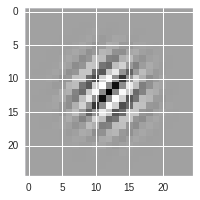

In [19]:
print np.real(gfm.filter_stack).dtype

#complex fs = np.stack([np.real(gfm.filter_stack), np.imag(gfm.filter_stack), np.zeros(shape=gfm.filter_stack.shape)]).transpose([1,2,3,4,0])
fs = np.real(gfm.filter_stack)
print fs.shape 
fig=plt.figure(figsize=(3,3))
plt.imshow(fs[15, 0, :, :], interpolation='None')

In [20]:
#filename = output_dir + "gabor_example.png"
#fig.patch.set_alpha(0.)
#fig.savefig(filename)
#plt.close()

In [21]:
##construct the model space
feat_dict = gfm.create_feature_maps(stim_data)

allocating memory for feature maps
constructing feature maps
feature 0 took 0.238406 s.
feature 1 took 0.262613 s.
feature 2 took 0.304353 s.
feature 3 took 0.386095 s.
feature 4 took 0.601835 s.
feature 5 took 1.009632 s.
feature 6 took 1.841390 s.
feature 7 took 3.348973 s.
feature 8 took 6.221238 s.
feature 9 took 11.452289 s.
feature 10 took 21.053905 s.
feature 11 took 38.270971 s.
feature 12 took 0.224387 s.
feature 13 took 0.247291 s.
feature 14 took 0.289613 s.
feature 15 took 0.385993 s.
feature 16 took 0.607484 s.
feature 17 took 1.011356 s.
feature 18 took 1.845520 s.
feature 19 took 3.340220 s.
feature 20 took 6.219329 s.
feature 21 took 11.553651 s.
feature 22 took 21.175909 s.
feature 23 took 38.279250 s.
feature 24 took 0.225034 s.
feature 25 took 0.246154 s.
feature 26 took 0.291367 s.
feature 27 took 0.386045 s.
feature 28 took 0.604562 s.
feature 29 took 1.011637 s.
feature 30 took 1.842210 s.
feature 31 took 3.336098 s.
feature 32 took 6.247171 s.
feature 33 took 11.

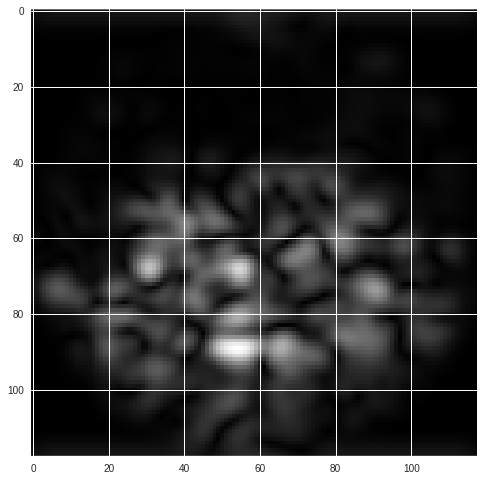

In [22]:
fmn = 7
fig=plt.figure(figsize=(8,8))
plt.imshow(feat_dict[fmn][3,0,:,:], cmap='gray', interpolation='None')

## Concatenate feature maps of the same resolution

In [23]:
log_act_func = lambda x: np.log(1+np.sqrt(x))
fmaps, _fmaps, fmaps_sizes = preprocess_gabor_feature_maps(feat_dict, log_act_func, dtype=fpX)

fmaps_res_count = len(fmaps_sizes)
fmaps_count = sum([fm[1] for fm in fmaps_sizes])
nf = fmaps_count # alias

[(1870, 4, 16, 16), (1870, 4, 21, 21), (1870, 4, 28, 28), (1870, 4, 37, 37), (1870, 4, 50, 50), (1870, 4, 66, 66), (1870, 4, 89, 89), (1870, 4, 118, 118), (1870, 4, 158, 158), (1870, 4, 211, 211), (1870, 4, 282, 282), (1870, 4, 376, 376)]
total fmaps = 48


In [24]:
del feat_dict

# 2) MODELS

## Define the inputs
We can either connect the feature maps of the network directly or some precomputed values provided in a suitable list

In [25]:
#feature maps symbolic variables
_invar = _fmaps
# vs.
#_fmaps = [L.get_output(fm, deterministic=True) for fm in _aux]
#_invar = [X,]

## Define the search parameters

In [26]:
lx = ly = 20.
nx = ny = 26
smin, smax = 0.5, 8.
ns = 12

# sharedModel specification is a list of 3 ranges and 3 callable functor. The reason for this is for a future implementation of dynamic mesh refinement.
sharedModel_specs = [[(0., lx), (0., ly), (smin, smax)], [prf.linspace(nx), prf.linspace(ny), prf.logspace(ns)]]
# initial values of the fwrf model parameters
voxelParams = [np.full(shape=(nv, nf), fill_value=0.0, dtype=fpX), np.full(shape=(nv), fill_value=0.0, dtype=fpX)]

print "G = %d\n" % (nx*ny*ns)
#print range:
print "range x"
print sharedModel_specs[1][0](*sharedModel_specs[0][0])
print "range y"
print sharedModel_specs[1][1](*sharedModel_specs[0][1])
print "range s"
print sharedModel_specs[1][2](*sharedModel_specs[0][2])



G = 8112

range x
[-9.61538506 -8.84615421 -8.07692337 -7.30769253 -6.53846169 -5.76923084
 -5.         -4.23076916 -3.46153855 -2.69230771 -1.92307687 -1.15384614
 -0.38461539  0.38461539  1.15384614  1.92307687  2.69230771  3.46153855
  4.23076916  5.          5.76923084  6.53846169  7.30769253  8.07692337
  8.84615421  9.61538506]
range y
[-9.61538506 -8.84615421 -8.07692337 -7.30769253 -6.53846169 -5.76923084
 -5.         -4.23076916 -3.46153855 -2.69230771 -1.92307687 -1.15384614
 -0.38461539  0.38461539  1.15384614  1.92307687  2.69230771  3.46153855
  4.23076916  5.          5.76923084  6.53846169  7.30769253  8.07692337
  8.84615421  9.61538506]
range s
[ 0.5         0.64333242  0.82775331  1.06504107  1.37035096  1.76318252
  2.26862502  2.91896009  3.75572371  4.83235788  6.21762514  8.        ]


[ 0.5         0.64333242  0.82775331  1.06504107  1.37035096  1.76318252
  2.26862502  2.91896009  3.75572371  4.83235788  6.21762514  8.        ]


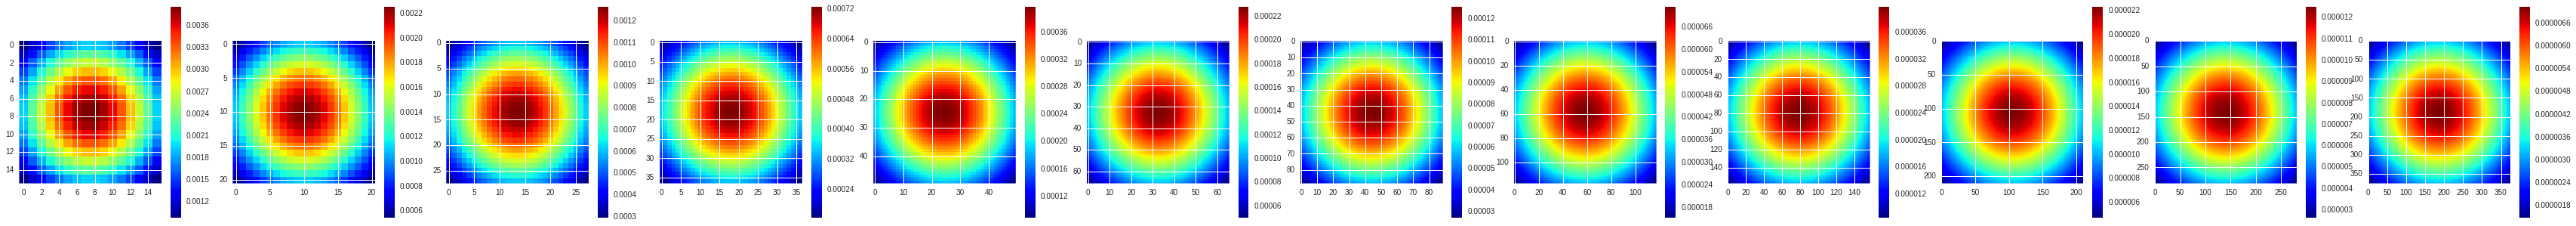

In [28]:
sigmas = sharedModel_specs[1][2](*sharedModel_specs[0][2])
print sigmas

ith_rf_size = 11
n = len(fmaps_sizes)
plt.figure(figsize=(5*n,5))
for i,r in enumerate(fmaps_sizes):
    _,_,z = pnu.make_gaussian_mass(0., 0., sigmas[ith_rf_size], r[2], size=20.)
    plt.subplot(1,n,i+1)
    plt.imshow(z, interpolation='None', cmap='jet')
    plt.colorbar()

(0, 10)

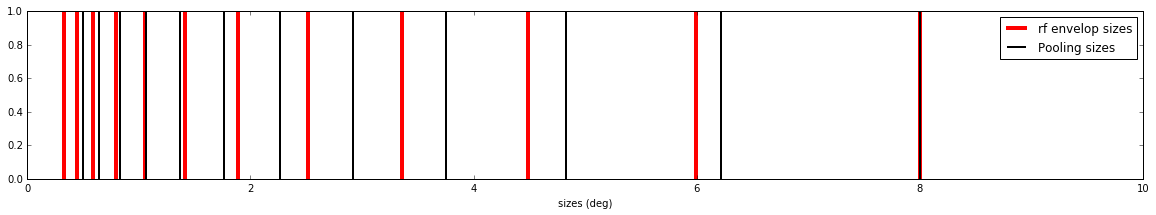

In [35]:
sigmas = sharedModel_specs[1][2](*sharedModel_specs[0][2])
env = 2. / np.logspace(np.log10(lowest_sp_freq),np.log10(highest_sp_freq), num_sp_freq)

fig_1 = plt.figure(figsize=(20,3))
plt.vlines(env, 0., 1., lw=4, color='r', label='rf envelop sizes')
plt.vlines(sigmas, 0., 1., lw=2, color='k', label='Pooling sizes')
#plt.xscale('log')
plt.xlabel('sizes (deg)')
plt.legend()
plt.xlim([0, 10])

## Define the model
This model needs to be batched at different stages

In [29]:
fwrf = FWRF_model(_fmaps, fmaps_sizes, _invar, fmaps_sizes,
    batches_p=(500, ny*nx), batches_o=(200, 1000, 2*ny*nx), batches_t=(500, 2*ny*nx),\
    view_angle=lx, verbose=True)

CREATING SYMBOLS

> feature map candidates 0 with shape (1, 676, 16, 16)
> feature map candidates 1 with shape (1, 676, 21, 21)
> feature map candidates 2 with shape (1, 676, 28, 28)
> feature map candidates 3 with shape (1, 676, 37, 37)
> feature map candidates 4 with shape (1, 676, 50, 50)
> feature map candidates 5 with shape (1, 676, 66, 66)
> feature map candidates 6 with shape (1, 676, 89, 89)
> feature map candidates 7 with shape (1, 676, 118, 118)
> feature map candidates 8 with shape (1, 676, 158, 158)
> feature map candidates 9 with shape (1, 676, 211, 211)
> feature map candidates 10 with shape (1, 676, 282, 282)
> feature map candidates 11 with shape (1, 676, 376, 376)
  total number of feature maps = 48, in 12 layers
  feature map candidate using approx 830.2 Mb of memory (VRAM and RAM)


Layer	: <lasagne.layers.input.InputLayer object at 0x7f1687f4bf10>
Name	: None
Type	: <class 'lasagne.layers.input.InputLayer'>
Shape	: (None, 48, 1352)


Layer	: <src.fwrf.svFWRFLayer ob

## Precompute and save the modelspace tensor

In [30]:
mst_data = fwrf.precompute_mst_data(fmaps, sharedModel_specs, verbose=True, dry_run=False, zscore=True, trn_size=trn_size, epsilon=1e-3)


>> Storing the full modelspace tensor will require approx 2.713Gb of RAM!
>> Will be divided in chunks of 0.452Gb of VRAM!

Precomputing mst candidate responses...


100%|██████████| 12/12 [02:34<00:00, 12.88s/it]

8112 mst candidate responses took 154.760s @ 52.417 models/s
Z-scoring modelspace tensor...



12it [00:10,  1.15it/s]


In [31]:
print mst_data.shape
print np.amin(mst_data), np.amax(mst_data)

(1870, 48, 1, 8112)
-7.56205 9.55846


In [40]:
trn_mst_data = mst_data[:trn_size]
val_mst_data = mst_data[trn_size:]

## Run the models

In [41]:
val_scores, best_scores, best_rf_params, best_candidates, best_w_params, best_avg, best_std = fwrf.shared_model_training(\
    trn_mst_data, trn_voxel_data, sharedModel_specs, voxelParams,\
    val_test_size=350, lr=1e-3, l2=0., num_epochs=20, output_val_scores=-1, verbose=True, dry_run=False)


Voxel-Candidates model optimization...
1 voxel batches of size 1000 with residual 0
6 candidate batches of size 1352 with residual 0
for 8112000 voxelmodel fits.


0it [00:00, ?it/s]


  Voxel 0:1000 of 1000, Candidate 0:1352 of 8112
    validation <loss>: 0.005684
    validation <loss>: 0.005682
    validation <loss>: 0.005681
    validation <loss>: 0.005681
    validation <loss>: 0.005681
    validation <loss>: 0.005681
    validation <loss>: 0.005681
    validation <loss>: 0.005681
    validation <loss>: 0.005681
    validation <loss>: 0.005681
    validation <loss>: 0.005681
    validation <loss>: 0.005681
    validation <loss>: 0.005682
    validation <loss>: 0.005682
    validation <loss>: 0.005682
    validation <loss>: 0.005682
    validation <loss>: 0.005682
    validation <loss>: 0.005683
    validation <loss>: 0.005683
    validation <loss>: 0.005683
    20 Epoch for 1352000 voxelmodels took 72.750s @ 18584.130 voxelmodels/s

  Voxel 0:1000 of 1000, Candidate 1352:2704 of 8112
    validation <loss>: 0.005682
    validation <loss>: 0.005680
    validation <loss>: 0.005678
    validation <loss>: 0.005678
    validation <loss>: 0.005678
    validation <loss>

1it [07:18, 438.62s/it]


---------------------------------------------------------------------
20 Epoch for 8112000 voxelmodels took 438.620s @ 18494.368 voxelmodels/s


[ 2.69230771  8.07692337  0.5       ]
score range = (0.003919, 0.005397)


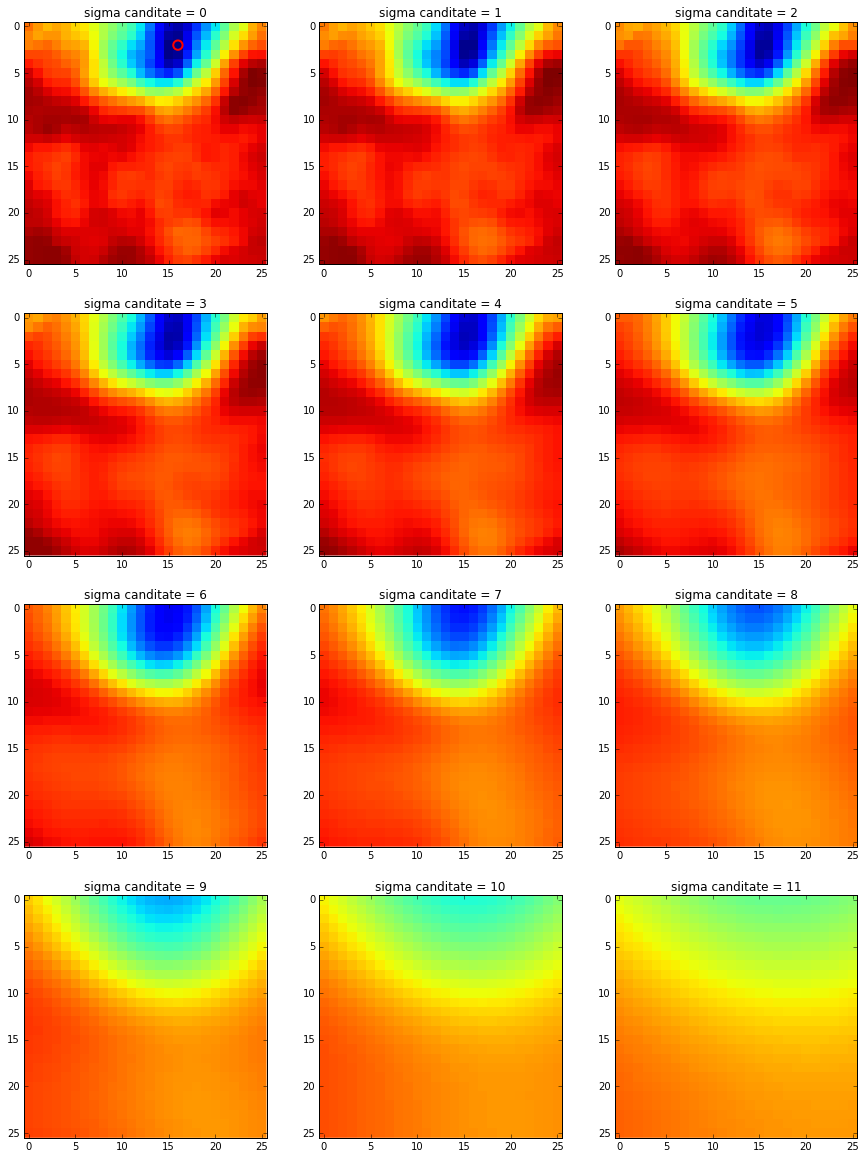

In [42]:
vidx = 566
print best_abs_models[vidx,:]
fig1 = display_candidate_loss(val_scores[-1,vidx,:], nx, ny, ns)

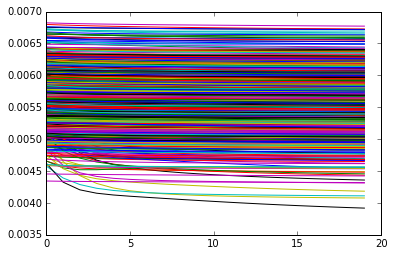

In [43]:
for v in range(val_scores.shape[1]):
    plt.plot(val_scores[:,v,best_candidates[v]])

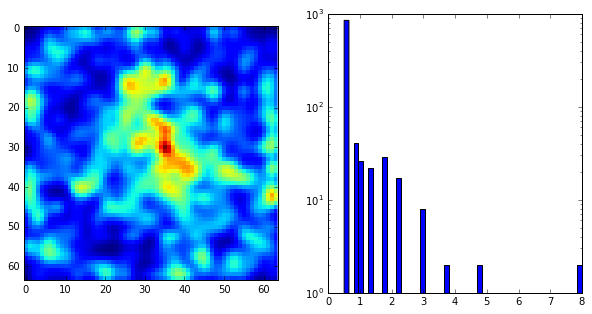

In [44]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
_,_,g_stack = pnu.make_gaussian_stack(best_rf_params[:,0], best_rf_params[:,1], best_rf_params[:,2], 64, size=20., dtype=fpX)
plt.imshow(np.sum(g_stack, axis=0), interpolation='None')
plt.subplot(1,2,2)
_=plt.hist(best_rf_params[:,2], bins=50)
plt.yscale('log')

# Test the models for validation CC

In [46]:
val_pred, val_cc = fwrf.validate_models(val_mst_data, val_voxel_data, best_candidates, best_w_params)

0 voxel batches of size 1352 with residual 1000


1it [00:00, 10.90it/s]


argmax cc = 566
max cc = 0.740256
sum(cc>0.2) = 140


(-0.4, 0.9)

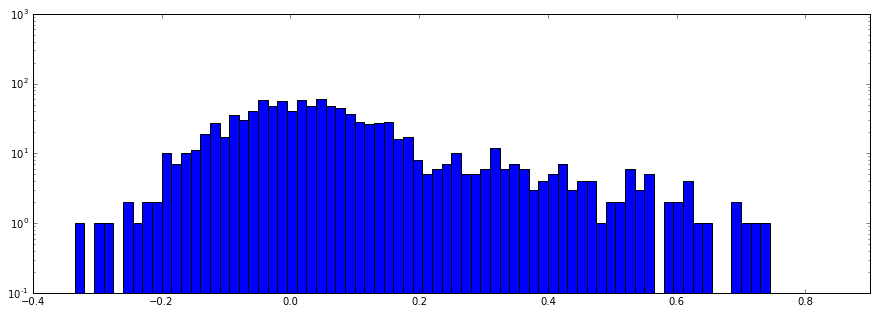

In [47]:
print "argmax cc = %d" % np.argmax(val_cc)
print "max cc = %f" % np.max(val_cc)
print "sum(cc>0.2) = %d" % np.sum(map(lambda x: x > 0.2, val_cc))
plt.figure(figsize=(15,5))
_=plt.hist(val_cc[:], bins=100, range=(-.5, 1.))
plt.yscale('log')
plt.ylim([10**-1, 10**3])
plt.xlim([-.4, 0.9])

[[ 1.        0.740256]
 [ 0.740256  1.      ]]


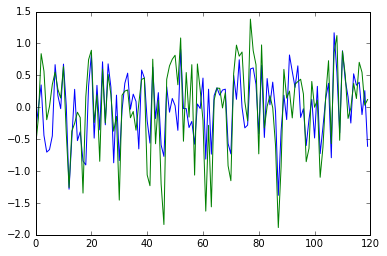

In [48]:
plt.plot(val_pred[:,vidx])
plt.plot(val_voxel_data[:,vidx])

print np.corrcoef(val_pred[:,vidx], val_voxel_data[:,vidx])

In [ ]:
***

In [40]:
ex_file_name = output_dir + "fwrf_%s_%s_%s_data.pkl" % (model_name, subject, timestamp)
ex_file = open(ex_file_name, 'wb')
ex_values = {'dataset': 'vim-1',
             'subject': subject,
             'model_name': model_name,
             'grid': [sharedModel_specs[1][0](*sharedModel_specs[0][0]), 
                      sharedModel_specs[1][1](*sharedModel_specs[0][1]),
                      sharedModel_specs[1][2](*sharedModel_specs[0][2])],
             'fmaps_res_count': fmaps_res_count,
             'fmaps_count': fmaps_count,
             'fmaps_sizes': fmaps_sizes,      
             'scores': best_scores,
             'rf_params': best_rf_params,
             'w_params': best_w_params,
             'normavg': best_avg,
             'normstd': best_std, 
             'val_pred': val_pred,
             'val_cc': val_cc}
pickle.dump(ex_values, ex_file)
ex_file.close()
print ex_file_name

/home/styvesg/Documents/PostDoc/Programs/JupyterNotebooks/fwrf-master/output/fwrf_S1_Mar-24-2017_1455_data.pkl


In [41]:
#data_file = open(output_dir + "fwrf_model_S1_Feb-17-2017_1812.pkl", 'rb')
#data_value = pickle.load(data_file)
#data_file.close()

# Split accuracy by layer and roi

In [42]:
#find the start and end point of the feature map partitions
fmaps_count = len(fmaps_sizes)
partitions = [0,]
for r in fmaps_sizes:
    partitions += [partitions[-1]+r[1],]
print partitions

[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48]


In [43]:
partition_val_pred = np.ndarray(shape=(fmaps_count,)+val_pred.shape, dtype=fpX)
partition_val_cc   = np.ndarray(shape=(fmaps_count,)+val_cc.shape, dtype=fpX)

for l in range(fmaps_count):
    partition_params = [np.zeros(p.shape, dtype=fpX) for p in best_params]  
    partition_params[0][:, partitions[l]:partitions[l+1]] = best_w_params[0][:, partitions[l]:partitions[l+1]]
    partition_params[1][:] = best_w_params[1][:]

    partition_val_pred[l,...], partition_val_cc[l,...] = fwrf.validate_models(val_mst_data, val_voxel_data, best_candidates, partition_params)

16 voxel batches of size 1352 with residual 1069


17it [00:01,  8.69it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.74it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.81it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.80it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.59it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.71it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.68it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.86it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.76it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.74it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.87it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.75it/s]


In [44]:
# calculate covariances
partition_r = np.ndarray(shape=(fmaps_count, nv))
for v in range(nv):
    full_c = np.cov(val_pred[:,v], val_voxel_data[:,v])
    for l in range(fmaps_count):
        part_c = np.cov(partition_val_pred[l,:,v], val_voxel_data[:,v])
        partition_r[l,v] = part_c[0,1]/np.sqrt(full_c[0,0]*full_c[1,1])

In [45]:
part_file = open(output_dir + "fwrf_%s_%s_%s_part.pkl" % (model_name, subject, timestamp), 'wb')
part_values = {'dataset': 'vim-1',
             'subject': subject,
             'model_name': model_name,
             'val_pred': partition_val_pred,
             'val_cc': partition_val_cc,
             'val_ri': partition_r}
pickle.dump(part_values, part_file)
part_file.close()

In [46]:
nROI = int(np.max(voxelROI))+1
nL   = fmaps_count

partition_R_avg = np.ndarray(shape=(fmaps_count, nROI), dtype=fpX)
partition_R_std = np.ndarray(shape=(fmaps_count, nROI), dtype=fpX)
for roi in range(nROI):
    roi_mask = np.logical_and(voxelROI.flatten()==roi, val_cc>0.2)    
    for l in range(fmaps_count):
        partition_R_avg[l,roi] = np.mean(partition_r[l, roi_mask] /  val_cc[roi_mask])
        partition_R_std[l,roi] = np.std(partition_r[l, roi_mask])
#plt.imshow(partition_R_avg, interpolation='None')

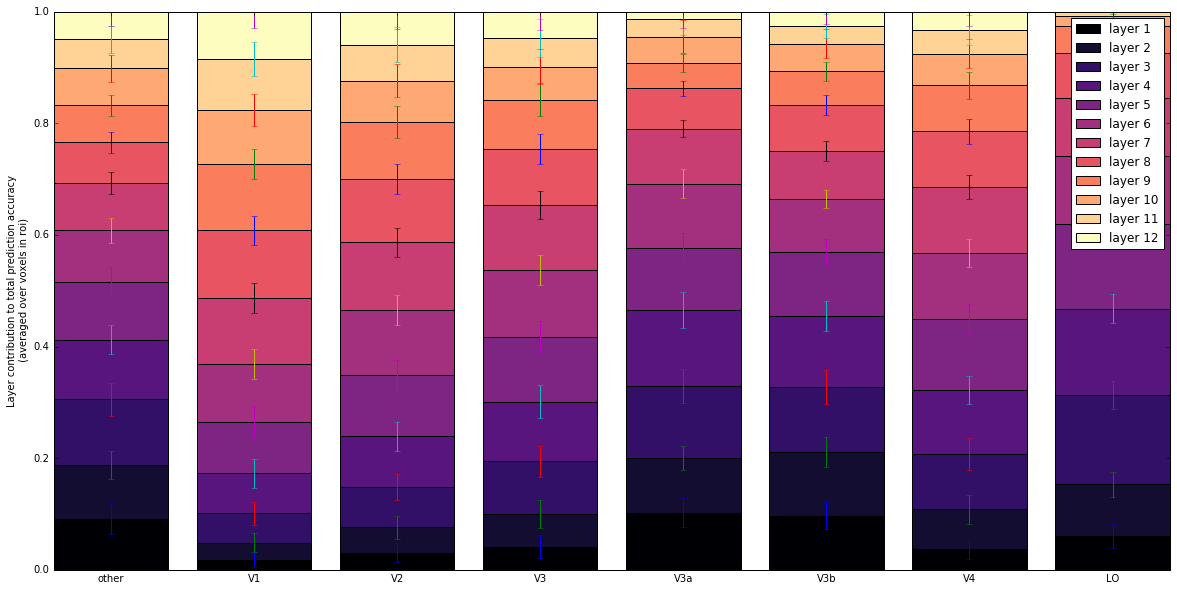

In [47]:
from matplotlib.pyplot import cm 
color=iter(cm.magma(np.linspace(0,1,nL)))

plt.figure(figsize=(20,10))
c=next(color)
plist = []
_ = plt.bar(np.arange(len(roi_names)), partition_R_avg[0,:], yerr=partition_R_std[0,:], color=c, align='center')
plist += [_,]
for l in range(1,nL):
    c=next(color)
    _= plt.bar(np.arange(len(roi_names)), partition_R_avg[l,:], bottom=np.sum(partition_R_avg[:l,:],axis=0), yerr=partition_R_std[l,:], color=c,\
        align='center', tick_label=roi_names)
    plist += [_,]
plt.legend(plist, ['layer %d' % l for l in range(1,len(plist)+1)])
plt.ylim([0,1])
plt.ylabel('Layer contribution to total prediction accuracy\n (averaged over voxels in roi)')